In [4]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, root_mean_squared_error
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from src.evaluate import evaluate_model
from scipy.stats import ttest_rel

import os

# Directories for smoothed and unsmoothed data
datasets = {
    'B-spline': './data/derived/smoothed/bspline/',
    'P-spline': './data/derived/smoothed/pspline/',
    'Unsmoothed': './data/derived/unsmoothed/'
}

In [ ]:
features_top10 = ['genome_lrtt', 'genome_ambig',
                  'gag_lrtt', 'gag_maf3c', 'gag_ambig',
                  'pol_maf3c', 'pol_ambig',
                  'gp120_lrtt',
                  'lrtt_coeff_1', 'lrtt_coeff_4']

# FEATURE SETS (NO META)

In [49]:
# Feature set with smoothed features (excluding meta-features)
features_smoothed_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                                'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                                'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                                'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips',
                                'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips']

features_tanya = ['gag_lrtt', 'gp120_lrtt', 'pol_lrtt',
                  'gp41_tips', 'gag_tips', 'gp120_tips',
                  'gp41_maf12c',
                  'gag_maf3c', 'gp41_maf3c']

features_top10_corr_no_meta = ['genome_lrtt','gag_lrtt', 'pol_lrtt',
                               'gp120_lrtt', 'gp120_maf12c', 'genome_maf3c', 
                               'gp41_maf3c', 'gag_maf3c', 'genome_maf12c', 'gp120_ambig']

features_top10_corr_no_ambig = ['genome_lrtt','gag_lrtt', 'pol_lrtt', 'gp120_lrtt', 
                                'genome_maf12c', 'gp120_maf12c', 
                                'genome_maf3c', 'gp41_maf3c', 'gag_maf3c', 'gp120_maf3c']

features_top10_fi_no_meta = ["genome_lrtt", "genome_maf12c",  "genome_ambig",
                             "gag_lrtt", "gag_maf3c", "gag_ambig",
                             "gp120_lrtt", "gp120_maf3c",
                             "pol_maf3c", "pol_ambig"]

features_top10_fi_no_ambig = ["genome_lrtt", "genome_maf12c", 
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c"]

features_top11_fi_no_meta = ["genome_lrtt", "genome_maf12c",  "genome_ambig",
                             "gag_lrtt", "gag_maf3c", "gag_ambig",
                             "gp120_lrtt", "gp120_maf3c",
                             "pol_maf3c", "pol_ambig",
                             "gp41_maf3c"]
features_top11_fi_no_ambig = ["genome_lrtt", "genome_maf12c", "genome_maf3c",
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c"]

features_top12_fi_no_meta = ["genome_lrtt", "genome_maf12c",  "genome_ambig",
                             "gag_lrtt", "gag_maf3c", "gag_ambig",
                             "gp120_lrtt", "gp120_maf3c", "gp120_ambig",
                             "pol_maf3c", "pol_ambig",
                             "gp41_maf3c"]

features_top12_fi_no_ambig = ["genome_lrtt", "genome_maf12c", "genome_maf3c", 
                             "gag_lrtt", "gag_maf3c", "gag_maf12c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c"]


# IMPACT OF BSPLINE SMOOTHING

In [50]:
feature_sets = [
    # Unsmoothed and Smoothed Feature Set
    {'name': 'common_features', 'features': features_smoothed_no_meta, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']},
    {'name': 'tanya', 'features': features_tanya, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']},
    {'name': 'Top10_corr_no_meta', 'features': features_top10_corr_no_ambig, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']},
    {'name': 'Top10_fi_no_meta', 'features': features_top10_fi_no_ambig, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']}, 
    {'name': 'Top11_fi_no_meta', 'features': features_top11_fi_no_ambig, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']}, 
    {'name': 'Top12_fi_no_meta', 'features': features_top12_fi_no_ambig, 'compatible_datasets': ['B-spline', 'P-spline', 'Unsmoothed']}, 

]

all_results = pd.DataFrame()

for feature_set in feature_sets:
    for dataset_type, input_dir in datasets.items():
        # Check if the feature set is compatible with the dataset
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Construct feature set name based on dataset type
        feature_set_name = f"{feature_set['name']}_{dataset_type}"
        
        # Debugging print statements
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type}")
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'], output_csv)
        metrics_df['Dataset_Type'] = dataset_type  # Track dataset used
        
        # Store results
        all_results = pd.concat([all_results, metrics_df], ignore_index=True)

# Save all results to a single CSV file
all_results.to_csv('all_performance_metrics.csv', index=False)
print("All performance metrics saved to 'all_performance_metrics.csv'")

Processing feature set: common_features with dataset: B-spline
Fold 1: MSE = 0.18985263595420712, MAE = 0.3420130415832152, R² = 0.33088341134127297
Fold 2: MSE = 0.1688087508225693, MAE = 0.28537364169117696, R² = 0.351697336431548
Fold 3: MSE = 0.24965268520335332, MAE = 0.37528296757763235, R² = 0.44307921968067876
Fold 4: MSE = 0.23359481649589495, MAE = 0.3826607786382506, R² = 0.45335781496953187
Fold 5: MSE = 0.2506495139078501, MAE = 0.37821171289863603, R² = 0.45627492573452133

Overall Performance across all folds:
Overall MSE: 0.2170222363616965
Overall MAE: 0.35123197211544754
Overall R²: 0.5462959944712421
Performance metrics saved to performance_metrics_Top12_fi_no_meta_Unsmoothed.csv
Processing feature set: common_features with dataset: P-spline
Fold 1: MSE = 0.18902326933320102, MAE = 0.33887056544395583, R² = 0.3338064308790626
Fold 2: MSE = 0.16066986644266776, MAE = 0.2764898371497808, R² = 0.3829543678132433
Fold 3: MSE = 0.24528038985060577, MAE = 0.381909240298172

In [51]:
overall_df = all_results[all_results['Fold'] == 'Overall']

# PLOT

In [52]:
overall_df['Simplified_Feature_Set'] = overall_df['Feature_Set'].replace({
    'common_features_B-spline': 'RFECV',
    'common_features_P-spline': 'RFECV',
    'common_features_Unsmoothed': 'RFECV',
    'Top10_corr_no_meta_B-spline': 'Top10 Correlated',
    'Top10_corr_no_meta_P-spline': 'Top10 Correlated',
    'Top10_corr_no_meta_Unsmoothed': 'Top10 Correlated',
    'Top10_fi_no_meta_Unsmoothed': 'Top10 Important',
    'Top10_fi_no_meta_P-spline': 'Top10 Important',
    'Top10_fi_no_meta_B-spline': 'Top10 Important',
    'Top11_fi_no_meta_Unsmoothed': 'Top11 Important',
    'Top11_fi_no_meta_P-spline': 'Top11 Important',
    'Top11_fi_no_meta_B-spline': 'Top11 Important',
    'Top12_fi_no_meta_Unsmoothed': 'Top12 Important',
    'Top12_fi_no_meta_P-spline': 'Top12 Important',
    'Top12_fi_no_meta_B-spline': 'Top12 Important',
    'tanya_Unsmoothed': 'Tanya',
    'tanya_B-spline': 'Tanya',
    'tanya_P-spline': 'Tanya',
})

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_14868/849256835.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_df['Simplified_Feature_Set'] = overall_df['Feature_Set'].replace({


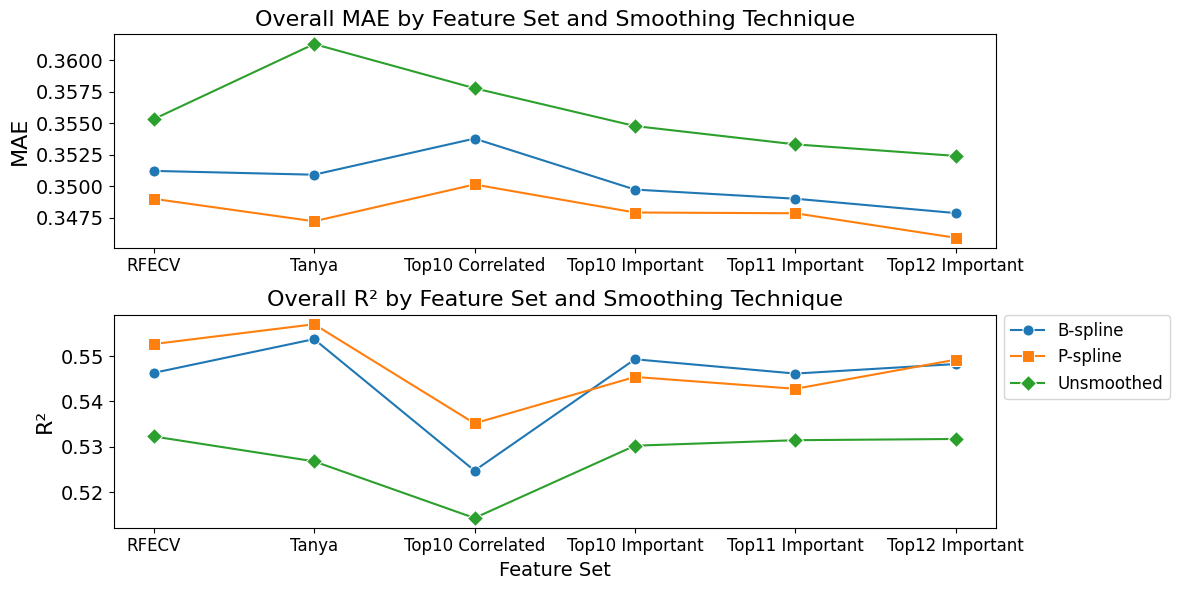

In [53]:
# Set up the plot
plt.figure(figsize=(14, 6))

markers = {'B-spline': 'o', 'P-spline': 's', 'Unsmoothed': 'D'}

# Plot MAE for 'Overall'
plt.subplot(2, 1, 1)
sns.lineplot(x='Simplified_Feature_Set', y='MAE', hue='Dataset_Type', style='Dataset_Type',
             markers=markers, dashes=False, data=overall_df, markersize = 8)
plt.title('Overall MAE by Feature Set and Smoothing Technique', fontsize = 16)
plt.xlabel('', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 12)
plt.ylabel('MAE', size = 16)
plt.legend([],[], frameon=False)
# Plot R² for 'Overall'
plt.subplot(2, 1, 2)
sns.lineplot(x='Simplified_Feature_Set', y='R²', hue='Dataset_Type', style='Dataset_Type',
             markers=markers, dashes=False, data=overall_df, markersize =8)
plt.title('Overall R² by Feature Set and Smoothing Technique', fontsize = 16)
plt.yticks(size = 14)
plt.xlabel('Feature Set', size = 14)
plt.xticks(size = 12)
plt.ylabel('R²', size = 16)
#move legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12) 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('./outputs/performance_comparisons/smoothing_comparison.pdf', bbox_inches='tight')
plt.show()

In [54]:
# Separate the data for unsmoothed, B-spline, and P-spline
unsmoothed_df = overall_df[overall_df['Dataset_Type'] == 'Unsmoothed']
bspline_df = overall_df[overall_df['Dataset_Type'] == 'B-spline']
pspline_df = overall_df[overall_df['Dataset_Type'] == 'P-spline']

# Paired t-test between unsmoothed and B-spline
t_stat_mae_bs, p_value_mae_bs = ttest_rel(unsmoothed_df['MAE'], bspline_df['MAE'])
t_stat_r2_bs, p_value_r2_bs = ttest_rel(unsmoothed_df['R²'], bspline_df['R²'])

# Paired t-test between unsmoothed and P-spline
t_stat_mae_ps, p_value_mae_ps = ttest_rel(unsmoothed_df['MAE'], pspline_df['MAE'])
t_stat_r2_ps, p_value_r2_ps = ttest_rel(unsmoothed_df['R²'], pspline_df['R²'])

# Display the results
print("Paired t-test for MAE (Unsmoothed vs B-spline): t-statistic = {}, p-value = {}".format(t_stat_mae_bs, p_value_mae_bs))
print("Paired t-test for R² (Unsmoothed vs B-spline): t-statistic = {}, p-value = {}".format(t_stat_r2_bs, p_value_r2_bs))

print("Paired t-test for MAE (Unsmoothed vs P-spline): t-statistic = {}, p-value = {}".format(t_stat_mae_ps, p_value_mae_ps))
print("Paired t-test for R² (Unsmoothed vs P-spline): t-statistic = {}, p-value = {}".format(t_stat_r2_ps, p_value_r2_ps))

Paired t-test for MAE (Unsmoothed vs B-spline): t-statistic = 5.357220646705303, p-value = 0.0030462141539194954
Paired t-test for R² (Unsmoothed vs B-spline): t-statistic = -7.324718244248065, p-value = 0.0007435473037190084
Paired t-test for MAE (Unsmoothed vs P-spline): t-statistic = 6.078357322645853, p-value = 0.0017418595872597301
Paired t-test for R² (Unsmoothed vs P-spline): t-statistic = -7.326427592107251, p-value = 0.0007427437980891565


### b-spline vs pspline

In [137]:
feature_sets_bvp = [
    # Smoothed Feature Sets with meta data (B-spline and P-spline)
    {'name': 'Set_1', 'features': f1_with_meta, 'compatible_datasets':['B-spline', 'P-spline']},
    {'name': 'Set_2', 'features': f2_with_meta, 'compatible_datasets':['B-spline', 'P-spline']},
    {'name': 'Set_5', 'features': f5_with_meta, 'compatible_datasets':['B-spline', 'P-spline']},
    {'name': 'Set_7', 'features': f7_with_meta, 'compatible_datasets':['B-spline', 'P-spline']},
    {'name': 'Set_10', 'features': f10_with_meta, 'compatible_datasets':['B-spline', 'P-spline']},
    {'name': 'Set_11', 'features': f11_with_meta, 'compatible_datasets':['B-spline', 'P-spline']},
    {'name': 'Set_Top10', 'features': features_top10, 'compatible_datasets':['B-spline', 'P-spline']},
    {'name': 'Set_Top10_FI', 'features': features_top10_fi, 'compatible_datasets':['B-spline', 'P-spline']}
]

all_results_bvp = pd.DataFrame()

for feature_set in feature_sets_bvp:
    for dataset_type, input_dir in datasets.items():
        # Check if the feature set is compatible with the dataset
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Construct feature set name based on dataset type
        feature_set_name = f"{feature_set['name']}_{dataset_type}"
        
        # Debugging print statements
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type}")
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Dataset_Type'] = dataset_type  # Track dataset used
        
        # Store results
        all_results_bvp = pd.concat([all_results_bvp, metrics_df], ignore_index=True)

# Save all results to a single CSV file
all_results_bvp.to_csv('performance_metrics_bvp_features.csv', index=False)
print("All performance metrics saved to 'performance_metrics_bvp_features.csv'")

Processing feature set: Set_1 with dataset: B-spline
Fold 1: MSE = 0.20431532793583213, MAE = 0.3509376331417043, R² = 0.2799111028825111
Fold 2: MSE = 0.16975663893844212, MAE = 0.27918462380583214, R² = 0.3480570133600792
Fold 3: MSE = 0.23960748286253816, MAE = 0.36889274473890415, R² = 0.4654878788206971
Fold 4: MSE = 0.22357729481918842, MAE = 0.3747911033035358, R² = 0.4768001157024385
Fold 5: MSE = 0.2414707782915744, MAE = 0.369081832121446, R² = 0.4761860303954205

Overall Performance across all folds:
Overall MSE: 0.21458726952063262
Overall MAE: 0.3472616625215423
Overall R²: 0.5513865060595531
Processing feature set: Set_1 with dataset: P-spline
Fold 1: MSE = 0.21247281080499364, MAE = 0.35767726754138207, R² = 0.2511608720415134
Fold 2: MSE = 0.15782868036217915, MAE = 0.2722132497853665, R² = 0.39386581935055376
Fold 3: MSE = 0.23149994824889755, MAE = 0.36788310800322455, R² = 0.4835740231768725
Fold 4: MSE = 0.21510858247416273, MAE = 0.36629311745246346, R² = 0.4966180

In [138]:
overall_bvp = all_results_bvp[all_results_bvp['Fold'] == 'Overall']

,Feature_Set,Fold,MSE,MAE,R²,Dataset_Type
5,Set_1_B-spline,Overall,0.214587,0.347262,0.551387,B-spline
11,Set_1_P-spline,Overall,0.208254,0.343346,0.564628,P-spline
17,Set_2_B-spline,Overall,0.215455,0.348071,0.549573,B-spline
23,Set_2_P-spline,Overall,0.206858,0.342888,0.567545,P-spline
29,Set_5_B-spline,Overall,0.216901,0.347121,0.546549,B-spline
35,Set_5_P-spline,Overall,0.207850,0.340916,0.565472,P-spline
41,Set_7_B-spline,Overall,0.217287,0.347243,0.545743,B-spline
47,Set_7_P-spline,Overall,0.210635,0.343706,0.559649,P-spline
53,Set_10_B-spline,Overall,0.213295,0.345929,0.554089,B-spline
59,Set_10_P-spline,Overall,0.210110,0.344932,0.560748,P-spline


In [143]:
overall_bvp['Simplified_Feature_Set'] = overall_bvp['Feature_Set'].replace({
    'Set_1_B-spline': 'Set 1',
    'Set_1_P-spline': 'Set 1',
    'Set_2_B-spline': 'Set 2',
    'Set_2_P-spline': 'Set 2',
    'Set_5_B-spline': 'Set 5',
    'Set_5_P-spline': 'Set 5',
    'Set_7_B-spline': 'Set 7',
    'Set_7_P-spline': 'Set 7',
    'Set_10_B-spline': 'Set 10',
    'Set_10_P-spline': 'Set 10',
    'Set_11_B-spline': 'Set 11',
    'Set_11_P-spline': 'Set 11',
    'Set_Top10_B-spline': 'Top10',
    'Set_Top10_P-spline': 'Top10',
    'Set_Top10_FI_P-spline': 'Top10 FI',
    'Set_Top10_FI_B-spline': 'Top10 FI',
})

/var/folders/rt/3hw_n0v124vg8h2q8kwnx3180000gn/T/ipykernel_91822/3081226661.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  overall_bvp['Simplified_Feature_Set'] = overall_bvp['Feature_Set'].replace({


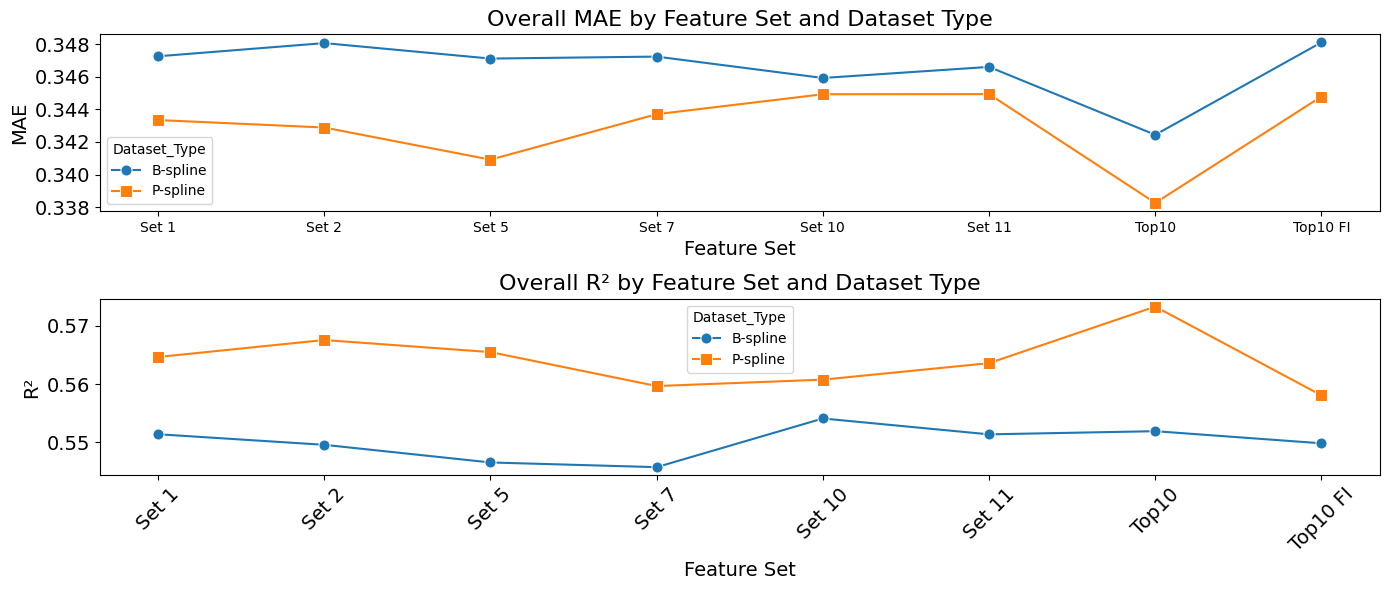

In [144]:
# Set up the plot
plt.figure(figsize=(14, 6))

markers = {'B-spline': 'o', 'P-spline': 's', 'Unsmoothed': 'D'}

# Plot MAE for 'Overall'
plt.subplot(2, 1, 1)
sns.lineplot(x='Simplified_Feature_Set', y='MAE', hue='Dataset_Type', style='Dataset_Type',
             markers=markers, dashes=False, data=overall_bvp, markersize = 8)
plt.title('Overall MAE by Feature Set and Dataset Type', fontsize = 16)
plt.xlabel('Feature Set', size = 14)
plt.yticks(size = 14)
plt.ylabel('MAE', size = 14)

# Plot R² for 'Overall'
plt.subplot(2, 1, 2)
sns.lineplot(x='Simplified_Feature_Set', y='R²', hue='Dataset_Type', style='Dataset_Type',
             markers=markers, dashes=False, data=overall_bvp, markersize =8)
plt.title('Overall R² by Feature Set and Dataset Type', fontsize = 16)
plt.yticks(size = 14)
plt.xlabel('Feature Set', size = 14)
plt.xticks(size = 14, rotation = 45)
plt.ylabel('R²', size = 14)

plt.tight_layout()
plt.show()

## C- statistical significance 

In [146]:
from scipy.stats import ttest_rel

# Separate the results by spline type
b_spline_mae = all_results_bvp[all_results_bvp['Dataset_Type'] == 'B-spline']['MAE']
p_spline_mae = all_results_bvp[all_results_bvp['Dataset_Type'] == 'P-spline']['MAE']

b_spline_r2 = all_results_bvp[all_results_bvp['Dataset_Type'] == 'B-spline']['R²']
p_spline_r2 = all_results_bvp[all_results_bvp['Dataset_Type'] == 'P-spline']['R²']

# Perform paired t-tests
t_stat_mae, p_value_mae = ttest_rel(b_spline_mae, p_spline_mae)
t_stat_r2, p_value_r2 = ttest_rel(b_spline_r2, p_spline_r2)

print(f"Paired t-test for MAE: t-statistic = {t_stat_mae}, p-value = {p_value_mae}")
print(f"Paired t-test for R²: t-statistic = {t_stat_r2}, p-value = {p_value_r2}")

Paired t-test for MAE: t-statistic = 3.0256888270569866, p-value = 0.0040147245541928
Paired t-test for R²: t-statistic = -4.266258032584962, p-value = 9.538004308614694e-05


# Impact of Meta Features 

In [5]:
f1_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                        'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                        'gp41_maf12c', 'gp41_maf3c',
                        'lrtt_coeff_1'] #meta features

f1_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips',
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                        'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                        'gp41_maf12c', 'gp41_maf3c'] 

f2_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                         'gp41_maf12c', 'gp41_maf3c',
                         'lrtt_coeff_1', 'lrtt_coeff_3'] #meta features
f2_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips',
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                         'gp41_maf12c', 'gp41_maf3c']

f5_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt', 
                         'gp120_lrtt', 'gp120_maf12c', 
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3'] #meta features
f5_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                            'gag_lrtt', 'gag_maf3c', 
                            'pol_lrtt', 
                            'gp120_lrtt', 'gp120_maf12c',
                            'gp41_maf3c'] 

f7_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt',
                         'gp120_lrtt', 'gp120_maf12c', 
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3', 'gp120_maf3c'] #meta features
f7_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt',
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c',
                         'gp41_maf3c']

f10_with_meta= ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                         'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips', 
                         'lrtt_coeff_1'] #meta feature
f10_no_meta= ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips',
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips',
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                         'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips']

f11_with_meta= ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                         'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips', 
                         'lrtt_coeff_1', 'lrtt_coeff_3']
f11_no_meta= ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips',
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips',
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips',
                         'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips']

f12_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                                'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                                'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                                'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                                'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips', 
                                'lrtt_coeff_1', 'lrtt_coeff_3', 'lrtt_coeff_11']  
f12_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                                'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                                'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                                'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                                'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips']

f13_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                                'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                                'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 
                                'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                                'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips', 
                                'lrtt_coeff_1', 'lrtt_coeff_3', 'lrtt_coeff_11'] #meta features
f13_no_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'genome_tips', 
                                'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                                'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 
                                'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                                'gp41_lrtt', 'gp41_maf12c', 'gp41_maf3c', 'gp41_tips'] #meta features

top10_fi_with_meta = ['genome_lrtt',
                     'gag_lrtt', 'gag_maf3c',
                     'pol_maf3c', 
                     'gp120_lrtt', 'gp120_maf3c',
                     'lrtt_coeff_1',
                     'maf12c_coeff_4',
                     'maf3c_coeff_0', 'maf3c_coeff_2']
   
top10_fi_no_meta = ["genome_lrtt", "genome_maf12c", 
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c"]

top11_fi_with_meta = ['genome_lrtt',
                     'gag_lrtt', 'gag_maf3c',
                     'pol_maf3c', 'pol_ambig',
                     'gp120_lrtt', 'gp120_maf3c',
                     'lrtt_coeff_1',
                     'maf3c_coeff_0', 'maf3c_coeff_2']

top11_fi_no_meta = ["genome_lrtt", "genome_maf12c", "genome_maf3c",
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c"]

## A - cross validation

In [6]:
feature_sets_meta = [
    # Smoothed Feature Sets with meta data (B-spline and P-spline)
    {'name': 'Set_1', 'Meta_Features':'no', 'features': f1_no_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set_1', 'Meta_Features':'yes', 'features': f1_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set_2', 'Meta_Features':'no', 'features': f2_no_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set_2','Meta_Features':'yes', 'features': f2_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set_5', 'Meta_Features':'no', 'features': f5_no_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set_5', 'Meta_Features':'yes', 'features': f5_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set_7', 'Meta_Features':'no', 'features': f7_no_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set_7', 'Meta_Features':'yes', 'features': f7_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top10_fi', 'Meta_Features':'no', 'features': top10_fi_no_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top10_fi', 'Meta_Features':'yes', 'features': top10_fi_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top11_fi', 'Meta_Features':'no', 'features': top11_fi_no_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top11_fi', 'Meta_Features':'yes', 'features': top11_fi_with_meta, 'compatible_datasets':['P-spline']},
]

all_results_meta = pd.DataFrame()

for feature_set in feature_sets_meta:
    for dataset_type, input_dir in datasets.items():
        # Check if the feature set is compatible with the dataset
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Construct feature set name based on dataset type
        feature_set_name = f"{feature_set['name']}_{dataset_type}"
        
        # Debugging print statements
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type}")
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Dataset_Type'] = dataset_type  # Track dataset used
        metrics_df['Meta_Features'] = feature_set['Meta_Features']
        
        # Store results
        all_results_meta = pd.concat([all_results_meta, metrics_df], ignore_index=True)

# Save all results to a single CSV file
all_results_meta.to_csv('performance_metrics_meta_features.csv', index=False)
print("All performance metrics saved to 'performance_metrics_meta_features.csv'")

Processing feature set: Set_1 with dataset: P-spline
Fold 1: MSE = 0.18766435498757447, MAE = 0.3350468184550475, R² = 0.3385957883017552
Fold 2: MSE = 0.15945991772475482, MAE = 0.27526006570075934, R² = 0.3876011232259925
Fold 3: MSE = 0.24714882201360386, MAE = 0.3829391968570318, R² = 0.44866479325587283
Fold 4: MSE = 0.243623738860624, MAE = 0.3871948175783783, R² = 0.4298888351471445
Fold 5: MSE = 0.2316995505730964, MAE = 0.3612793894027482, R² = 0.49738240709714265

Overall Performance across all folds:
Overall MSE: 0.21248427206161288
Overall MAE: 0.346791033076444
Overall R²: 0.5557830065600081
Processing feature set: Set_1 with dataset: P-spline
Fold 1: MSE = 0.20884141172799028, MAE = 0.35712247294876787, R² = 0.26395937415474724
Fold 2: MSE = 0.15622756224573356, MAE = 0.27576122910307854, R² = 0.40001484382067976
Fold 3: MSE = 0.22629385081921224, MAE = 0.3669015225496169, R² = 0.4951876929461243
Fold 4: MSE = 0.22867626765969992, MAE = 0.37331528473521547, R² = 0.4648678

## B - sig test

In [22]:
t_test_results = []

# Metrics to compare
metrics = ['MAE', 'R²']

# Identify unique feature sets
feature_sets = all_results_meta['Feature_Set'].unique()

# Loop through each metric and perform the paired t-test
for metric in metrics:
    no_meta = []
    with_meta = []
    
    for feature_set in feature_sets:
        # Extract performance metrics for models without meta features
        no_meta_value = all_results_meta[(all_results_meta['Feature_Set'] == feature_set) &
                                         (all_results_meta['Meta_Features'] == 'no') &
                                         (all_results_meta['Fold'] == 'Overall')][metric].values
        # Extract performance metrics for models with meta features
        with_meta_value = all_results_meta[(all_results_meta['Feature_Set'] == feature_set) &
                                           (all_results_meta['Meta_Features'] == 'yes') &
                                           (all_results_meta['Fold'] == 'Overall')][metric].values
        
        # Ensure that both values are present
        if no_meta_value.size > 0 and with_meta_value.size > 0:
            no_meta.append(no_meta_value[0])
            with_meta.append(with_meta_value[0])

    # Perform paired t-test for the current metric
    t_statistic, p_value = ttest_rel(no_meta, with_meta)
    t_test_results.append((metric, t_statistic, p_value))

# Display results with Bonferroni correction
alpha_corrected = 0.05 / len(metrics)

for metric, t_stat, p_val in t_test_results:
    print(f"Paired t-test for {metric}: t-statistic = {t_stat}, p-value = {p_val}")
    if p_val < alpha_corrected:
        print(f"The result for {metric} is significant after Bonferroni correction (p < {alpha_corrected}).")
    else:
        print(f"The result for {metric} is not significant after Bonferroni correction (p >= {alpha_corrected}).")

Paired t-test for MAE: t-statistic = 1.411062018252556, p-value = 0.21731086963803756
The result for MAE is not significant after Bonferroni correction (p >= 0.025).
Paired t-test for R²: t-statistic = -3.635515935079113, p-value = 0.014973684070556971
The result for R² is significant after Bonferroni correction (p < 0.025).


In [23]:
overall_meta = all_results_meta[all_results_meta['Fold'] == 'Overall']

# Impact of Ambiguities

## A- Most Correlated Ambiguity

In [98]:
f1_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                        'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                        'gp41_maf12c', 'gp41_maf3c',
                        'lrtt_coeff_1'] #meta features
f1_with_ambig = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                        'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                        'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                        'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                        'gp41_maf12c', 'gp41_maf3c',
                        'lrtt_coeff_1'] #meta features

f2_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                         'gp41_maf12c', 'gp41_maf3c',
                         'lrtt_coeff_1', 'lrtt_coeff_3'] #meta features
f2_with_ambig = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                         'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                         'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp120_ambig',
                         'gp41_maf12c', 'gp41_maf3c',
                         'lrtt_coeff_1', 'lrtt_coeff_3'] #meta features

f5_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt', 
                         'gp120_lrtt', 'gp120_maf12c', 
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3'] #meta features
f5_with_ambig = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt', 
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_ambig',
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3']

f7_with_ambig = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt',
                         'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_ambig',
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3']
f7_with_meta = ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                         'gag_lrtt', 'gag_maf3c', 
                         'pol_lrtt',
                         'gp120_lrtt', 'gp120_maf12c', 
                         'gp41_maf3c', 
                         'lrtt_coeff_1', 'lrtt_coeff_3', 'gp120_maf3c'] #meta features

top10_fi_with_meta = ['genome_lrtt',
                     'gag_lrtt', 'gag_maf3c',
                     'pol_maf3c', 
                     'gp120_lrtt', 'gp120_maf3c',
                     'lrtt_coeff_1',
                     'maf12c_coeff_4',
                     'maf3c_coeff_0', 'maf3c_coeff_2']
top10_fi_with_ambig = ["genome_lrtt", "genome_maf12c", 
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c", 'gp120_ambig']

top11_fi_with_meta = ['genome_lrtt',
                     'gag_lrtt', 'gag_maf3c',
                     'pol_maf3c', 
                     'gp120_lrtt', 'gp120_maf3c',
                     'lrtt_coeff_1',
                     'maf3c_coeff_0', 'maf3c_coeff_2']
top11_fi_with_ambig = ["genome_lrtt", "genome_maf12c", "genome_maf3c",
                             "gag_lrtt", "gag_maf3c",
                             "gp120_lrtt", "gp120_maf3c", "gp120_tips",
                             "pol_lrtt","pol_maf3c",
                             "gp41_maf3c", "gp120_ambig"]

In [99]:
feature_sets_ambig = [
    # Smoothed Feature Sets with meta data (B-spline and P-spline)
    {'name': 'Set 1', 'Ambiguity_Features':'gp120_ambig', 'features': f1_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Set 1', 'Ambiguity_Features':'none', 'features': f1_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 2', 'Ambiguity_Features':'gp120_ambig', 'features': f2_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Set 2','Ambiguity_Features':'none', 'features': f2_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 5', 'Ambiguity_Features':'gp120_ambig', 'features': f5_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Set 5', 'Ambiguity_Features':'none', 'features': f5_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Set 7', 'Ambiguity_Features':'gp120_ambig', 'features': f7_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Set 7', 'Ambiguity_Features':'none', 'features': f7_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top10 Important', 'Ambiguity_Features':'gp120_ambig', 'features': top10_fi_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Top10 Important', 'Ambiguity_Features':'none', 'features': top10_fi_with_meta, 'compatible_datasets':['P-spline']},
    {'name': 'Top11 Important', 'Ambiguity_Features':'gp120_ambig', 'features': top11_fi_with_ambig, 'compatible_datasets':['P-spline']},
    {'name': 'Top11 Important', 'Ambiguity_Features':'none', 'features': top11_fi_with_meta, 'compatible_datasets':['P-spline']},
]

In [100]:
all_results_ambig = pd.DataFrame()

for feature_set in feature_sets_ambig:
    for dataset_type, input_dir in datasets.items():
        # Check if the feature set is compatible with the dataset
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Construct feature set name based on dataset type
        feature_set_name = f"{feature_set['name']}"
        
        # Debugging print statements
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type}")
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Ambiguity_Features'] = feature_set['Ambiguity_Features']
        
        # Store results
        all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)

# Save all results to a single CSV file
all_results_ambig.to_csv('performance_metrics_ambiguity_features.csv', index=False)
print("All performance metrics saved to 'performance_metrics_ambiguity_features.csv'")

Processing feature set: Set 1 with dataset: P-spline
Fold 1: MSE = 0.19347974329890924, MAE = 0.34381469797319325, R² = 0.31810003500842343
Fold 2: MSE = 0.15029259132392253, MAE = 0.2696539314046008, R² = 0.4228078414470622
Fold 3: MSE = 0.22769914303133332, MAE = 0.36880820461605085, R² = 0.4920527920148019
Fold 4: MSE = 0.23049913254675766, MAE = 0.37614235851807726, R² = 0.46060211714842836
Fold 5: MSE = 0.2284252731921082, MAE = 0.356681982618016, R² = 0.5044851805451618

Overall Performance across all folds:
Overall MSE: 0.20479177093708756
Overall MAE: 0.3416528258830866
Overall R²: 0.5718648543523923
Processing feature set: Set 1 with dataset: P-spline
Fold 1: MSE = 0.20884141172799028, MAE = 0.35712247294876787, R² = 0.26395937415474724
Fold 2: MSE = 0.15622756224573356, MAE = 0.27576122910307854, R² = 0.40001484382067976
Fold 3: MSE = 0.22629385081921224, MAE = 0.3669015225496169, R² = 0.4951876929461243
Fold 4: MSE = 0.22867626765969992, MAE = 0.37331528473521547, R² = 0.464

In [101]:
overall_ambig = all_results_ambig[all_results_ambig['Fold'] == 'Overall']

### plot

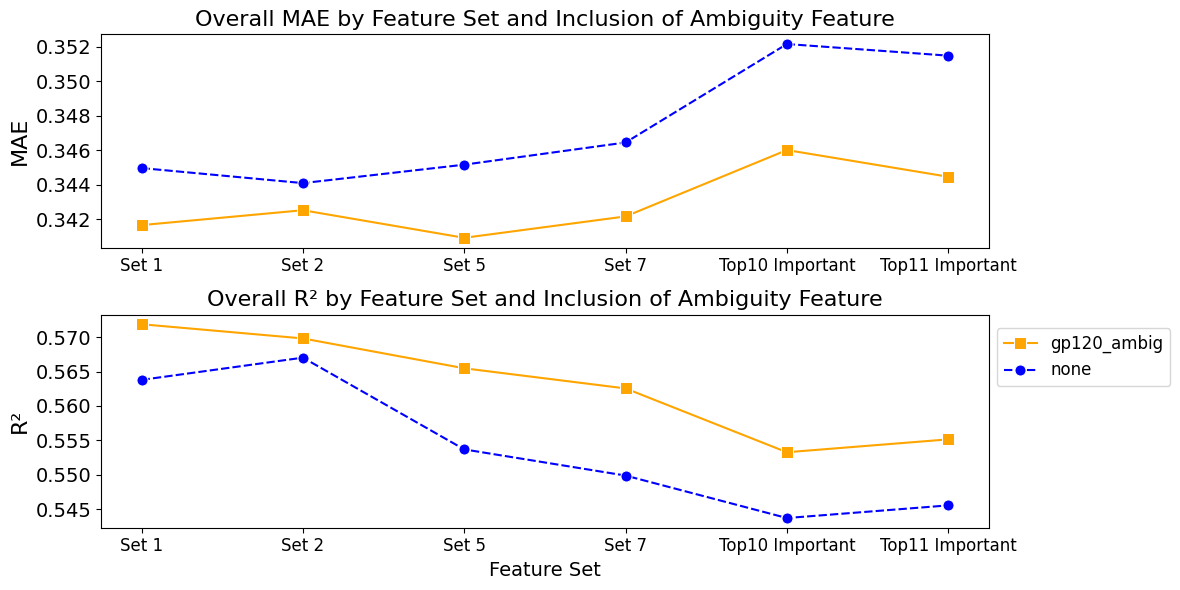

In [102]:
plt.figure(figsize=(14, 6))

markers = {'none': 'o', 'gp120_ambig': 's'}

# Plot MAE for 'Overall'
plt.subplot(2, 1, 1)
sns.lineplot(x='Feature_Set', y='MAE', 
             hue='Ambiguity_Features', 
             palette=['orange', 'blue'],
             style='Ambiguity_Features',
             markers=markers, markersize = 8, 
             data=overall_ambig)
plt.title('Overall MAE by Feature Set and Inclusion of Ambiguity Feature', fontsize = 16)
plt.xlabel('', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 12)
plt.ylabel('MAE', size = 16)
plt.legend([],[], frameon=False)
# Plot R² for 'Overall'
plt.subplot(2, 1, 2)
sns.lineplot(x='Feature_Set', y='R²', 
             hue='Ambiguity_Features', 
             palette=['orange', 'blue'],
             style='Ambiguity_Features',
             markers=markers,
            dashes=True, data=overall_ambig, markersize =8)
plt.title('Overall R² by Feature Set and Inclusion of Ambiguity Feature', fontsize = 16)
plt.yticks(size = 14)
plt.xlabel('Feature Set', size = 14)
plt.xticks(size = 12)
plt.ylabel('R²', size = 16)
#move legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12) 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('./outputs/performance_comparisons/gp120_ambiguity_comparison.pdf', bbox_inches='tight')
plt.show()

### SIG TEST

In [103]:
t_test_results = []

# Metrics to compare
metrics = ['MAE', 'R²']

# Identify unique feature sets
feature_sets = overall_ambig['Feature_Set'].unique()

# Loop through each metric and perform the paired t-test
for metric in metrics:
    with_ambiguity = []
    without_ambiguity = []
    
    for feature_set in feature_sets:
        # Extract performance metrics for models without ambiguity features
        without_ambiguity_value = overall_ambig[(overall_ambig['Feature_Set'] == feature_set) &
                                                (overall_ambig['Ambiguity_Features'] == 'none')][metric].values
        # Extract performance metrics for models with ambiguity features
        with_ambiguity_value = overall_ambig[(overall_ambig['Feature_Set'] == feature_set) &
                                             (overall_ambig['Ambiguity_Features'] == 'gp120_ambig')][metric].values
        
        # Ensure that both values are present
        if without_ambiguity_value.size > 0 and with_ambiguity_value.size > 0:
            without_ambiguity.append(without_ambiguity_value[0])
            with_ambiguity.append(with_ambiguity_value[0])

    # Perform paired t-test for the current metric
    t_statistic, p_value = ttest_rel(without_ambiguity, with_ambiguity)
    t_test_results.append((metric, t_statistic, p_value))

# Display results with Bonferroni correction
alpha_corrected = 0.05 / len(metrics)

for metric, t_stat, p_val in t_test_results:
    print(f"Paired t-test for {metric}: t-statistic = {t_stat}, p-value = {p_val}")
    if p_val < alpha_corrected:
        print(f"The result for {metric} is significant after Bonferroni correction (p < {alpha_corrected}).")
    else:
        print(f"The result for {metric} is not significant after Bonferroni correction (p >= {alpha_corrected}).")

Paired t-test for MAE: t-statistic = 5.543815152237016, p-value = 0.0026220681813092324
The result for MAE is significant after Bonferroni correction (p < 0.025).
Paired t-test for R²: t-statistic = -6.358178705464978, p-value = 0.001422055991497052
The result for R² is significant after Bonferroni correction (p < 0.025).


## B - Most Important Ambiguity

In [104]:
feature_sets_with_meta = {
    'f1_with_meta': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                     'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                     'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                     'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                     'gp41_maf12c', 'gp41_maf3c',
                     'lrtt_coeff_1'],
    'f2_with_meta': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 
                     'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 
                     'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 
                     'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 
                     'gp41_maf12c', 'gp41_maf3c',
                     'lrtt_coeff_1', 'lrtt_coeff_3'],
    'f5_with_meta': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                     'gag_lrtt', 'gag_maf3c', 
                     'pol_lrtt', 
                     'gp120_lrtt', 'gp120_maf12c', 
                     'gp41_maf3c', 
                     'lrtt_coeff_1', 'lrtt_coeff_3'],
    'f7_with_meta': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c',
                     'gag_lrtt', 'gag_maf3c', 
                     'pol_lrtt',
                     'gp120_lrtt', 'gp120_maf12c', 
                     'gp41_maf3c', 
                     'lrtt_coeff_1', 'lrtt_coeff_3', 'gp120_maf3c'],
    'top10_fi_with_meta': ['genome_lrtt',
                           'gag_lrtt', 'gag_maf3c',
                           'pol_maf3c', 
                           'gp120_lrtt', 'gp120_maf3c',
                           'lrtt_coeff_1',
                           'maf12c_coeff_4',
                           'maf3c_coeff_0', 'maf3c_coeff_2'],
    'top11_fi_with_meta': ['genome_lrtt',
                           'gag_lrtt', 'gag_maf3c',
                           'pol_maf3c', 
                           'gp120_lrtt', 'gp120_maf3c',
                           'lrtt_coeff_1',
                           'maf3c_coeff_0', 'maf3c_coeff_2']
}

feature_sets_with_ambig = {}

# Loop through each feature set, add 'pol_ambig', and rename
for key, features in feature_sets_with_meta.items():
    # Create a copy of the feature set
    new_key = key.replace('_with_meta', '_with_ambig')
    new_features = features.copy()
    
    # Add 'pol_ambig' to the new feature set if not already present
    if 'pol_ambig' not in new_features:
        new_features.append('pol_ambig')
    
    # Store the new feature set in the new dictionary
    feature_sets_with_ambig[new_key] = new_features


In [109]:
feature_sets_ambig = []

# Loop through each feature set and create entries with and without 'pol_ambig'
for name, features in feature_sets_with_meta.items():
    # Create the feature set with ambiguity
    features_with_ambig = features.copy()
    if 'pol_ambig' not in features_with_ambig:
        features_with_ambig.append('pol_ambig')
    
    # Add the entries to the feature_sets_ambig list
    feature_sets_ambig.append({
        'name': name, 
        'Ambiguity_Features': 'pol_ambig', 
        'features': features_with_ambig, 
        'compatible_datasets': ['P-spline']
    })
    
    # Add the original feature set without ambiguity
    feature_sets_ambig.append({
        'name': name, 
        'Ambiguity_Features': 'none', 
        'features': features, 
        'compatible_datasets': ['P-spline']
    })

# Output the updated feature_sets_ambig list to verify
for entry in feature_sets_ambig:
    print(entry)

{'name': 'f1_with_meta', 'Ambiguity_Features': 'pol_ambig', 'features': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp41_maf12c', 'gp41_maf3c', 'lrtt_coeff_1', 'pol_ambig'], 'compatible_datasets': ['P-spline']}
{'name': 'f1_with_meta', 'Ambiguity_Features': 'none', 'features': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'gp120_lrtt', 'gp120_maf12c', 'gp120_maf3c', 'gp120_tips', 'gp41_maf12c', 'gp41_maf3c', 'lrtt_coeff_1'], 'compatible_datasets': ['P-spline']}
{'name': 'f2_with_meta', 'Ambiguity_Features': 'pol_ambig', 'features': ['genome_lrtt', 'genome_maf12c', 'genome_maf3c', 'gag_lrtt', 'gag_maf12c', 'gag_maf3c', 'gag_tips', 'pol_lrtt', 'pol_maf12c', 'pol_maf3c', 'pol_tips', 'gp120_lrtt', 'gp120_maf12c', 'gp120_ma

In [110]:
all_results_ambig = pd.DataFrame()

for feature_set in feature_sets_ambig:
    for dataset_type, input_dir in datasets.items():
        # Check if the feature set is compatible with the dataset
        if dataset_type not in feature_set['compatible_datasets']:
            continue
        
        # Construct feature set name based on dataset type
        feature_set_name = f"{feature_set['name']}"
        
        # Debugging print statements
        print(f"Processing feature set: {feature_set['name']} with dataset: {dataset_type}")
        
        # Evaluate model
        metrics_df = evaluate_model(input_dir, feature_set_name, feature_set['features'])
        metrics_df['Ambiguity_Features'] = feature_set['Ambiguity_Features']
        
        # Store results
        all_results_ambig = pd.concat([all_results_ambig, metrics_df], ignore_index=True)

# Save all results to a single CSV file
all_results_ambig.to_csv('performance_metrics_ambiguity_features.csv', index=False)
print("All performance metrics saved to 'performance_metrics_ambiguity_features.csv'")

Processing feature set: f1_with_meta with dataset: P-spline
Fold 1: MSE = 0.2076451383600234, MAE = 0.35572601935723275, R² = 0.2681755197513265
Fold 2: MSE = 0.15578756163597368, MAE = 0.2732894732155991, R² = 0.40170464702039
Fold 3: MSE = 0.22262674744149608, MAE = 0.3631015689848654, R² = 0.5033682020921236
Fold 4: MSE = 0.22327452492053096, MAE = 0.3681800560718569, R² = 0.4775086365568235
Fold 5: MSE = 0.22982836088131653, MAE = 0.35957839570916067, R² = 0.5014415123324389

Overall Performance across all folds:
Overall MSE: 0.20677437171565846
Overall MAE: 0.34278575095905206
Overall R²: 0.5677200536643057
Processing feature set: f1_with_meta with dataset: P-spline
Fold 1: MSE = 0.20884141172799028, MAE = 0.35712247294876787, R² = 0.26395937415474724
Fold 2: MSE = 0.15622756224573356, MAE = 0.27576122910307854, R² = 0.40001484382067976
Fold 3: MSE = 0.22629385081921224, MAE = 0.3669015225496169, R² = 0.4951876929461243
Fold 4: MSE = 0.22867626765969992, MAE = 0.37331528473521547,

In [112]:
overall_ambig = all_results_ambig[all_results_ambig['Fold'] == 'Overall']

### plot

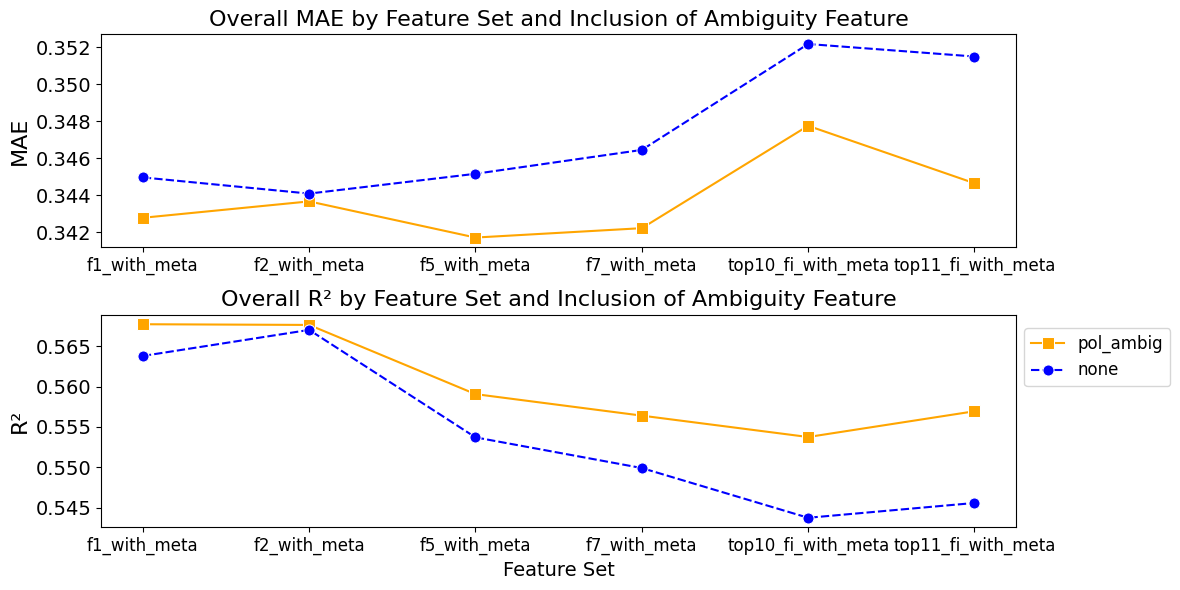

In [113]:
plt.figure(figsize=(14, 6))

markers = {'none': 'o', 'pol_ambig': 's'}

# Plot MAE for 'Overall'
plt.subplot(2, 1, 1)
sns.lineplot(x='Feature_Set', y='MAE', 
             hue='Ambiguity_Features', 
             palette=['orange', 'blue'],
             style='Ambiguity_Features',
             markers=markers, markersize = 8, 
             data=overall_ambig)
plt.title('Overall MAE by Feature Set and Inclusion of Ambiguity Feature', fontsize = 16)
plt.xlabel('', size = 14)
plt.yticks(size = 14)
plt.xticks(size = 12)
plt.ylabel('MAE', size = 16)
plt.legend([],[], frameon=False)
# Plot R² for 'Overall'
plt.subplot(2, 1, 2)
sns.lineplot(x='Feature_Set', y='R²', 
             hue='Ambiguity_Features', 
             palette=['orange', 'blue'],
             style='Ambiguity_Features',
             markers=markers,
            dashes=True, data=overall_ambig, markersize =8)
plt.title('Overall R² by Feature Set and Inclusion of Ambiguity Feature', fontsize = 16)
plt.yticks(size = 14)
plt.xlabel('Feature Set', size = 14)
plt.xticks(size = 12)
plt.ylabel('R²', size = 16)
#move legend
plt.legend(loc='center left', bbox_to_anchor=(1, 0.8), fontsize=12) 
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('./outputs/performance_comparisons/pol_ambiguity_comparison.pdf', bbox_inches='tight')
plt.show()

In [114]:
t_test_results = []

# Metrics to compare
metrics = ['MAE', 'R²']

# Identify unique feature sets
feature_sets = overall_ambig['Feature_Set'].unique()

# Loop through each metric and perform the paired t-test
for metric in metrics:
    with_ambiguity = []
    without_ambiguity = []
    
    for feature_set in feature_sets:
        # Extract performance metrics for models without ambiguity features
        without_ambiguity_value = overall_ambig[(overall_ambig['Feature_Set'] == feature_set) &
                                                (overall_ambig['Ambiguity_Features'] == 'none')][metric].values
        # Extract performance metrics for models with ambiguity features
        with_ambiguity_value = overall_ambig[(overall_ambig['Feature_Set'] == feature_set) &
                                             (overall_ambig['Ambiguity_Features'] == 'pol_ambig')][metric].values
        
        # Ensure that both values are present
        if without_ambiguity_value.size > 0 and with_ambiguity_value.size > 0:
            without_ambiguity.append(without_ambiguity_value[0])
            with_ambiguity.append(with_ambiguity_value[0])

    # Perform paired t-test for the current metric
    t_statistic, p_value = ttest_rel(without_ambiguity, with_ambiguity)
    t_test_results.append((metric, t_statistic, p_value))

# Display results with Bonferroni correction
alpha_corrected = 0.05 / len(metrics)

for metric, t_stat, p_val in t_test_results:
    print(f"Paired t-test for {metric}: t-statistic = {t_stat}, p-value = {p_val}")
    if p_val < alpha_corrected:
        print(f"The result for {metric} is significant after Bonferroni correction (p < {alpha_corrected}).")
    else:
        print(f"The result for {metric} is not significant after Bonferroni correction (p >= {alpha_corrected}).")

Paired t-test for MAE: t-statistic = 4.035215433630231, p-value = 0.00996970146093463
The result for MAE is significant after Bonferroni correction (p < 0.025).
Paired t-test for R²: t-statistic = -3.8980797288893636, p-value = 0.011431393980780852
The result for R² is significant after Bonferroni correction (p < 0.025).
